# Automating Non-GAAP Metric Extraction from 8-Ks

**Adjusted EBITDA, Free Cash Flow, and Core Earnings** are central to financial analysis—often more informative than GAAP figures. But extracting these metrics from earnings releases and 8-Ks is difficult. Formats are inconsistent, terminology varies, and key tables are often buried deep in unstructured disclosures.

**Traditional tools** (regex, templates, table parsers) struggle with this inconsistency, making extraction slow, manual, and error-prone.

Captide uses a **retrieval-augmented generation (RAG) API** to pull metrics like Adjusted EBITDA from SEC filings. It returns structured, schema-consistent JSON—even from messy source documents—making the data ready for modeling or analysis.

We first collect recent 8-Ks (Item 2.02) using a `fetch_documents` function. Then we send a structured prompt to Captide to extract Net Income to Adjusted EBITDA reconciliations.

In [44]:
import os

CAPTIDE_API_KEY = os.getenv("CAPTIDE_API_KEY")

HEADERS = {
    "X-API-Key": CAPTIDE_API_KEY,
    "Content-Type": "application/json",
    "Accept": "application/json"
}

TICKERS = ["PLTR"]

In [45]:
import re, json, requests, pandas as pd
from typing import Dict, List

def is_valid_fiscal_period(fp: str) -> bool:
    m = re.match(r"Q([1-4]) (\d{4})", fp)
    return bool(m and int(m.group(2)) > 2022)

def is_valid_document(doc: Dict) -> bool:
    if doc["sourceType"] == "8-K":
        return "2.02" in doc.get("additionalKwargs", {}).get("item", "")
    return True

def fetch_documents(ticker: str) -> List[Dict]:
    url = f"https://rest-api.captide.co/api/v1/companies/ticker/{ticker}/documents"
    docs = requests.get(url, headers=HEADERS, timeout=60).json()
    return [
        {"ticker": doc["ticker"],
         "fiscalPeriod": doc["fiscalPeriod"],
         "sourceLink": doc["sourceLink"]}
        for doc in docs
        if doc["sourceType"] == "8-K"
        and "fiscalPeriod" in doc
        and is_valid_fiscal_period(doc["fiscalPeriod"])
        and is_valid_document(doc)
    ]

In [46]:
def parse_sse_response(sse_text: str) -> Dict:
    try:
        lines = [l[6:] for l in sse_text.splitlines() if l.startswith("data: ")]
        for l in lines:
            obj = json.loads(l)
            if obj.get("type") == "full_answer":
                content = re.sub(r"\s*\[#\w+\]", "", obj["content"])
                m = re.search(r"\{.*\}", content, re.DOTALL)
                return json.loads(m.group(0)) if m else {}
    except Exception:
        pass
    return {}

def fetch_metrics_with_prompt(source_links: List[str], prompt: str) -> Dict:
    payload = {"query": prompt, "sourceLink": source_links}
    r = requests.post(
        "https://rest-api.captide.co/api/v1/rag/agent-query-stream",
        json=payload, headers=HEADERS, timeout=120
    )
    return parse_sse_response(r.text)

Reconciliation formats change across quarters. To handle this, we dynamically learn a stable schema using previous reconciliations as a guide. This avoids rigid templates while maintaining consistency—critical for time-series analysis.

In [47]:
BASE_PROMPT = (
    "Return a single valid JSON object with double-quoted keys and numeric values. The object must represent the reconciliation "
    "from Net Income to Adjusted EBITDA, including all reported line items and adjusted EBITDA. Numeric values must be converted "
    "to thousands of USD, and the keys must be the name of each line item, but adapted to more common naming conventions if needed. "
    "Do not include words like 'add' or 'less' in the keys. Use positive values for metrics that are added to Net Income in the "
    "reconciliation and negative values for metrics that are subtracted. Output only the JSON object—no commentary or extra text."
)

def build_prompt(prev_keys: List[str]) -> str:
    if not prev_keys:
        return BASE_PROMPT
    joined = ", ".join(f'"{k}"' for k in prev_keys)
    return (
        BASE_PROMPT +
        f" Try to fit the values into the following keys if they appear (in this order): [{joined}]. Be flexible but accurate. "
        "If the document contains additional reconciliation line items, insert them at the correct position relative to the list above."
    )

def merge_key_lists(master: list[str], this_quarter: list[str]) -> list[str]:
    for i, k in enumerate(this_quarter):
        if k in master:
            continue
        insert_pos = None
        for j in range(i - 1, -1, -1):
            prev_key = this_quarter[j]
            if prev_key in master:
                insert_pos = master.index(prev_key) + 1
                break
        if insert_pos is None:
            for j in range(i + 1, len(this_quarter)):
                nxt_key = this_quarter[j]
                if nxt_key in master:
                    insert_pos = master.index(nxt_key)
                    break
        if insert_pos is None:
            insert_pos = len(master)
        master.insert(insert_pos, k)
    return master

Using ```run_one_ticker```, we batch process filings for each company, normalize the results, and align the schema. This creates a per-ticker dictionary of clean, time-indexed financial data—ready for modeling or dashboards.

In [48]:
def fiscal_sort_key(fp: str) -> tuple[int, int]:
    m = re.match(r"Q([1-4]) (\d{4})", fp)
    if not m:
        return (9999, 9)
    q, yr = int(m.group(1)), int(m.group(2))
    return (yr, q)

def run_one_ticker(ticker: str) -> Dict[str, Dict[str, float]]:
    docs = fetch_documents(ticker)
    docs.sort(key=lambda d: fiscal_sort_key(d["fiscalPeriod"]))

    key_order: List[str] = []
    results: Dict[str, Dict[str, float]] = {}

    for doc in docs:
        prompt = build_prompt(key_order)
        data = fetch_metrics_with_prompt([doc["sourceLink"]], prompt)
        if not data:
            continue
        results[doc["fiscalPeriod"]] = data
        key_order = merge_key_lists(key_order, list(data.keys()))

    return {"keys": key_order, "data": results}

In [49]:
from concurrent.futures import ThreadPoolExecutor, as_completed

per_ticker_output = {}
with ThreadPoolExecutor(max_workers=len(TICKERS)) as pool:
    futures = {pool.submit(run_one_ticker, t): t for t in TICKERS}
    for fut in as_completed(futures):
        ticker = futures[fut]
        per_ticker_output[ticker] = fut.result()

We convert each company’s results into a tidy pandas.DataFrame:

Reconciliation of Net Income to EBITDA for PLTR


,Q1 2023,Q2 2023,Q3 2023,Q4 2023,Q1 2024,Q2 2024,Q3 2024,Q4 2024,Q1 2025
Line item,,,,,,,,,
Net income attributable to common stockholders,16802,28127,71505,93391,105530,134126,143525,79009,214031
Net income attributable to noncontrolling interests,2349,-255,1934,3522,541,1444,5816,-2073,3686
Interest income,-20853,-30310,-36864,-44545,-43352,-46593,-52120,-54727,-50441
Interest expense,1275,1317,742,136,0,0,0,0,0
"Other income (expense), net",2861,9024,-3864,3956,13507,11173,8110,-14768,3173
Provision for income taxes,1681,2171,6530,9334,4655,5189,7809,3602,5599
Depreciation and amortization,8320,8399,8663,7972,8438,8056,8087,7006,6622
Stock-based compensation,114714,114201,114380,132608,125651,141764,142425,281798,155339
Employer payroll taxes related to stock-based compensation,6285,10760,8909,10953,19926,6464,19950,79681,59323


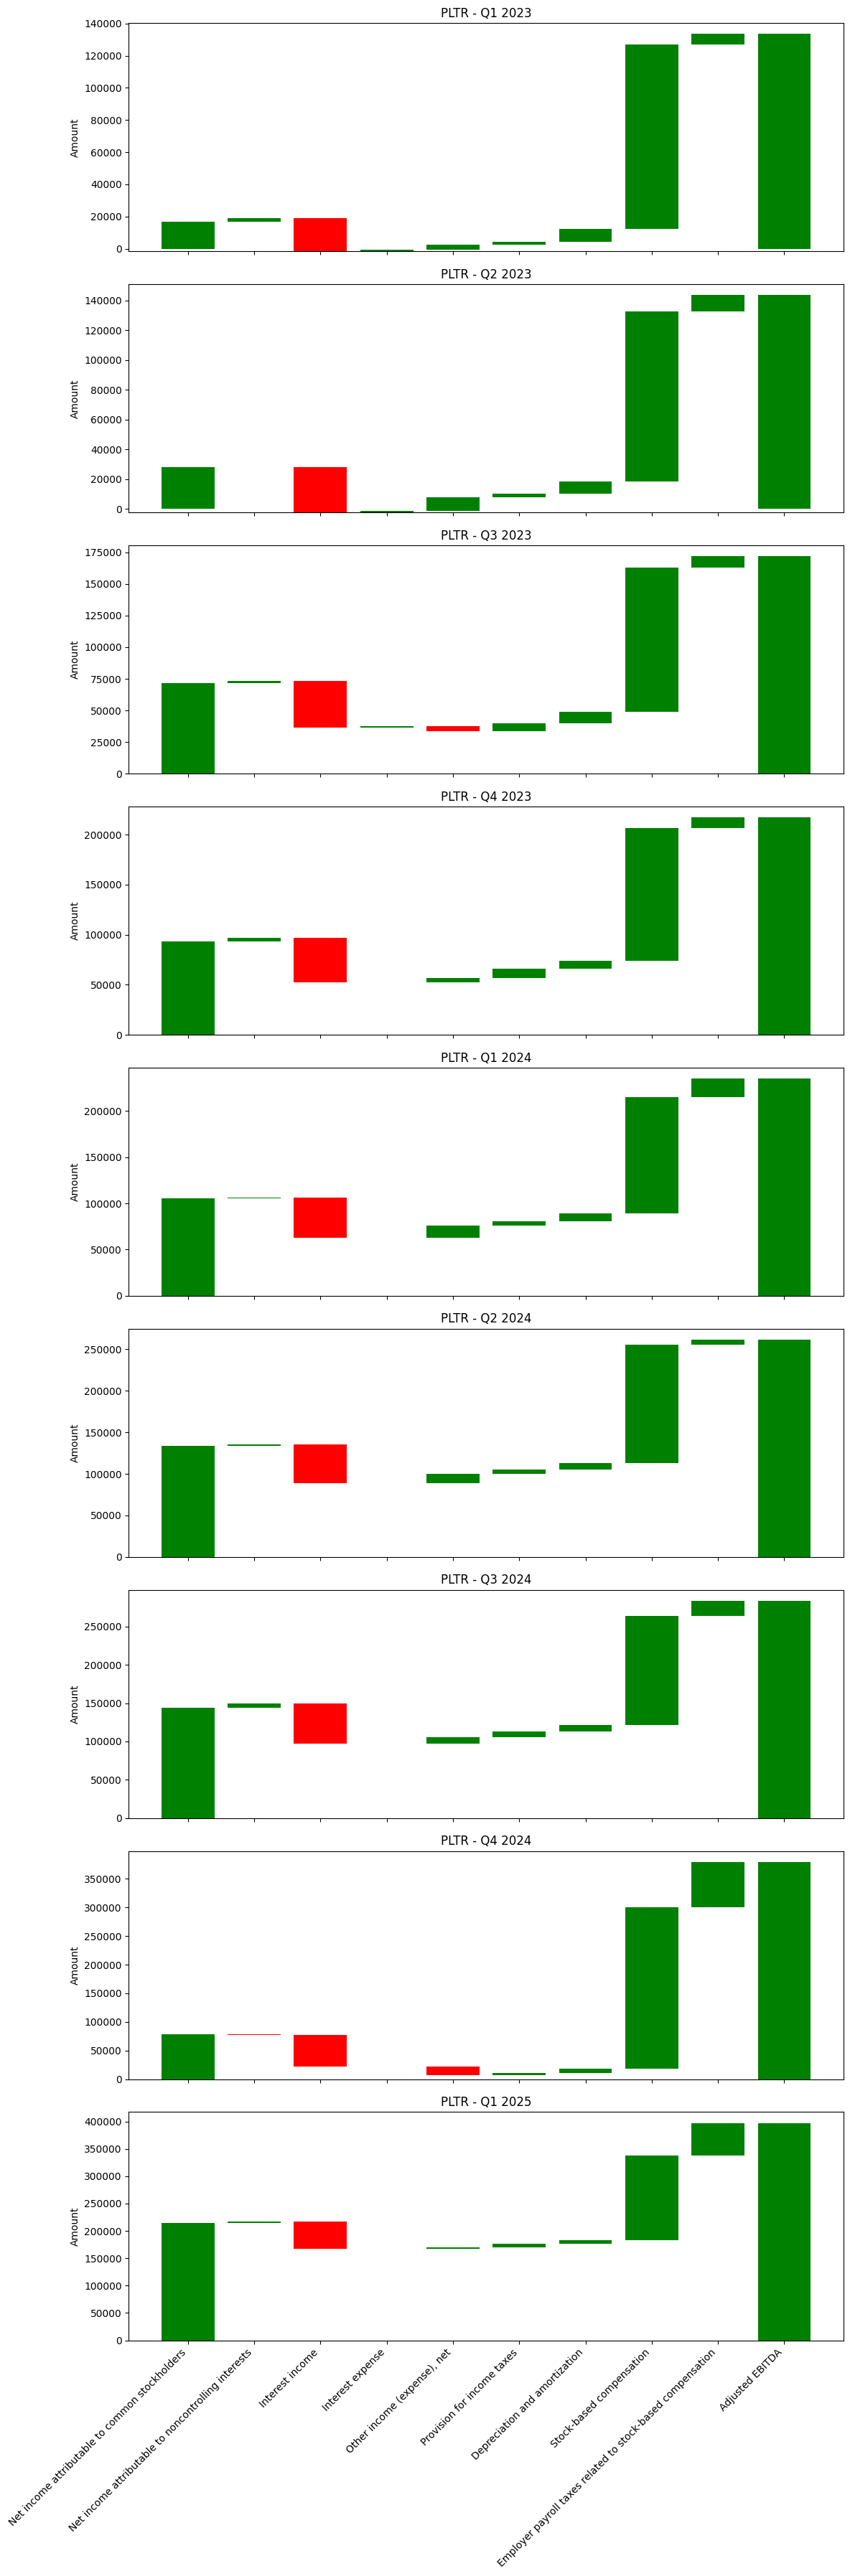

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

tables = {}
for ticker, payload in per_ticker_output.items():
    key_order = payload["keys"]
    series_by_q = payload["data"]
    df = pd.DataFrame(series_by_q).reindex(key_order)
    df.index.name = "Line item"
    
    # Replace NaNs with 0 and convert all numeric values to integers
    df = df.fillna(0).astype(int)
    tables[ticker] = df

for t, frame in tables.items():
    print(f"Reconciliation of Net Income to EBITDA for {t}")
    display(frame)

    # Get chart data
    cols = frame.columns
    index = frame.index.tolist()
    num_charts = len(cols)

    fig, axs = plt.subplots(nrows=num_charts, figsize=(12, 4 * num_charts), sharex=True)

    if num_charts == 1:
        axs = [axs]  # ensure iterable if only one subplot

    for i, col in enumerate(cols):
        data = frame[col]
        values = data.values.tolist()

        # Bottom values: cumulative for all but last, last starts at 0
        bottom = [0]
        for val in values[:-2]:
            bottom.append(bottom[-1] + val)
        bottom.append(0)

        colors = ['green' if v >= 0 else 'red' for v in values]

        axs[i].bar(index, values, bottom=bottom, color=colors)
        axs[i].set_title(f"{t} - {col}")
        axs[i].set_ylabel("Amount")

        # Only show x-axis labels on the last subplot
        if i < num_charts - 1:
            axs[i].set_xticklabels([])
        else:
            axs[i].set_xticks(range(len(index)))
            axs[i].set_xticklabels(index, rotation=45, ha='right')

    plt.tight_layout()
    plt.show()